In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSMEC

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSMEC


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.6MB/s 
     |████████████████████████████████| 3.3MB 50.8MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train = pd.read_excel("/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSMEC/train_nor_811.xlsx", index_col=False)
dev = pd.read_excel("/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSMEC/valid_nor_811.xlsx", index_col=False)
test = pd.read_excel("/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSMEC/test_nor_811.xlsx", index_col=False)

X_train = train['Sentence']
y_train = train['Emotion'].values

X_dev = dev['Sentence']
y_dev = dev['Emotion'].values

X_test = test['Sentence']
y_test = test['Emotion'].values

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
num_labels = len(np.unique(y_test))

In [ ]:
path_model = "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSMEC/results_1/checkpoint-16500"

In [ ]:
# Khai bao pre-trained

phobert = RobertaForSequenceClassification.from_pretrained(path_model, num_labels = num_labels)
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_encodings = phobert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = phobert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = phobert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSMEC/le.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

phobert_trainer = Trainer(
    model=phobert,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
phobert_trainer.train()

Step,Training Loss
500,1.430500
1000,0.573400
1500,0.208800
2000,0.108500
2500,0.068900
3000,0.053400
3500,0.043400
4000,0.040400
4500,0.038600
5000,0.019800


TrainOutput(global_step=17400, training_loss=0.08144118613424314, metrics={'train_runtime': 5191.8551, 'train_samples_per_second': 106.86, 'train_steps_per_second': 3.351, 'total_flos': 1.797600667056e+16, 'train_loss': 0.08144118613424314, 'epoch': 100.0})

In [ ]:
# Du doan 
y_pred_classify = phobert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
y_true = y_test_encoding
print(pd.Series(y_test).unique())
print(pd.Series(y_true).unique())

['Sadness' 'Surprise' 'Disgust' 'Fear' 'Anger' 'Other' 'Enjoyment']
[5 6 1 3 0 4 2]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = y_test_encoding
y_pred_classify = phobert_trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_test).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels=pd.Series(y_true).unique(), target_names=target_names))

[[ 83   1   9   4   0   7  12]
 [  3  23   2   0   0   3   6]
 [  7   3  78  11   9  14  10]
 [  2   0   3  35   0   4   2]
 [  2   1  13   2  17   4   1]
 [ 14   5  19   2   3  63  23]
 [ 14   3  14   4   2  20 136]]
accuracy: 0.6277056277056277
F1 - macro: 0.6107482596196553
Classification report in Training set
              precision    recall  f1-score   support

     Sadness       0.66      0.72      0.69       116
    Surprise       0.64      0.62      0.63        37
     Disgust       0.57      0.59      0.58       132
        Fear       0.60      0.76      0.67        46
       Anger       0.55      0.42      0.48        40
       Other       0.55      0.49      0.52       129
   Enjoyment       0.72      0.70      0.71       193

    accuracy                           0.63       693
   macro avg       0.61      0.62      0.61       693
weighted avg       0.63      0.63      0.63       693



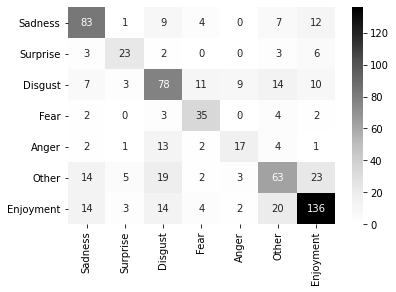

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = pd.Series(y_test).unique(),
                  columns = pd.Series(y_test).unique())

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})